Using device: cuda


Training Episodes:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 0, Total Reward: -2458.139179335689, Path Length: 300
Episode 100, Total Reward: -492.08607008158907, Path Length: 300
Episode 200, Total Reward: -436.2838107908198, Path Length: 300
Episode 300, Total Reward: -928.1006853039496, Path Length: 300
Episode 400, Total Reward: -494.6487210808582, Path Length: 300
Episode 500, Total Reward: -326.60472948949695, Path Length: 300
Episode 600, Total Reward: -40.380987050938856, Path Length: 283
Episode 700, Total Reward: -413.81509965094614, Path Length: 300
Episode 800, Total Reward: 247.88884279506883, Path Length: 235
Episode 900, Total Reward: -372.77750848177124, Path Length: 300


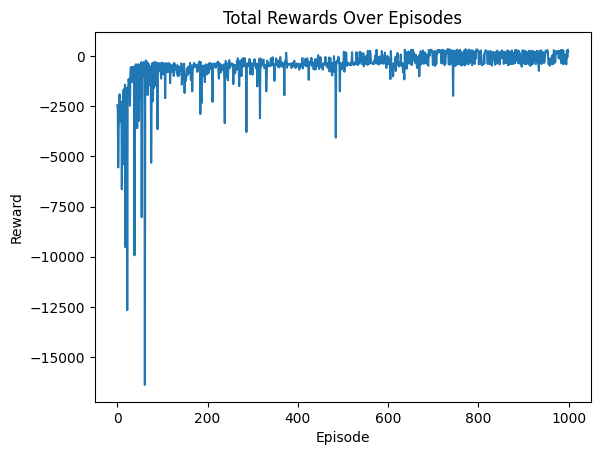

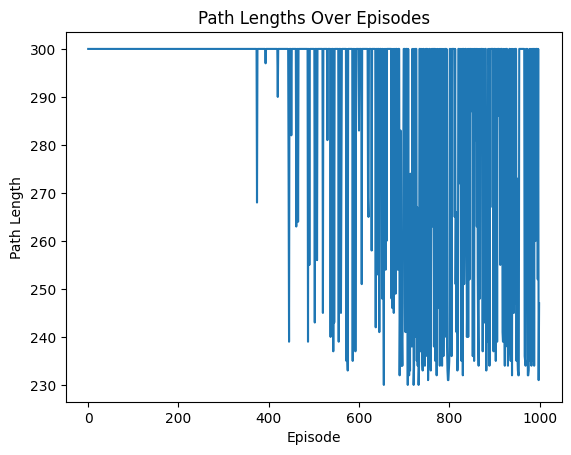

In [2]:
import numpy as np
from numba import jit, float64, int64, boolean
from datetime import datetime, timedelta
import json
import os
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import namedtuple
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# CUDA 디바이스 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 경험 저장을 위한 named tuple 정의
Experience = namedtuple('Experience', ('state', 'action', 'reward', 'next_state', 'done'))

# Dueling DQN 네트워크 정의
class DuelingDQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DuelingDQN, self).__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.value_stream = nn.Linear(64, 1)
        self.advantage_stream = nn.Linear(64, action_dim)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        value = self.value_stream(x)
        advantage = self.advantage_stream(x)
        q_values = value + (advantage - advantage.mean(dim=1, keepdim=True))
        return q_values

# SumTree 클래스 (PER 우선순위 관리)
class SumTree:
    def __init__(self, capacity):
        self.capacity = capacity
        self.tree = np.zeros(2 * capacity - 1)
        self.data = np.zeros(capacity, dtype=object)
        self.write = 0
        self.n_entries = 0

    def add(self, priority, data):
        idx = self.write + self.capacity - 1
        self.data[self.write] = data
        self.update(idx, priority)
        self.write = (self.write + 1) % self.capacity
        if self.n_entries < self.capacity:
            self.n_entries += 1

    def update(self, idx, priority):
        change = priority - self.tree[idx]
        self.tree[idx] = priority
        while idx != 0:
            idx = (idx - 1) // 2
            self.tree[idx] += change

    def get(self, s):
        idx = 0
        while True:
            left = 2 * idx + 1
            right = left + 1
            if left >= len(self.tree):
                break
            if s <= self.tree[left]:
                idx = left
            else:
                s -= self.tree[left]
                idx = right
        data_idx = idx - self.capacity + 1
        return idx, self.tree[idx], self.data[data_idx]

    def total(self):
        return self.tree[0]

# Numba로 최적화된 연료 소비 계산 함수
@jit(nopython=True)
def calculate_fuel_consumption(abs_action_angle, position, tidal_grid_dir, tidal_grid_speed, tidal_grid_valid, 
                               wind_grid_dir, wind_grid_speed, wind_grid_valid, k_w, n_rows, n_cols, f_0 = 1, V_s = 6.68):
    row, col = position
    tidal_dir, tidal_speed = 0.0, 0.0
    if 0 <= row < n_rows and 0 <= col < n_cols and tidal_grid_valid[row, col]:
        tidal_dir = tidal_grid_dir[row, col]
        tidal_speed = tidal_grid_speed[row, col]
    wind_dir, wind_speed = 0.0, 0.0
    if 0 <= row < n_rows and 0 <= col < n_cols and wind_grid_valid[row, col]:
        wind_dir = wind_grid_dir[row, col]
        wind_speed = wind_grid_speed[row, col]
    
    tidal_dir_rad = (90.0 - tidal_dir) * np.pi / 180.0
    wind_dir_rad = (90.0 - wind_dir) * np.pi / 180.0
    action_angle_rad = (90.0 - abs_action_angle) * np.pi / 180.0
    
    theta_c = action_angle_rad - tidal_dir_rad
    theta_w = action_angle_rad - wind_dir_rad
    
    # 조류의 영향을 반영한 속도 비율 계산
    tidal_effect = (V_s - tidal_speed * np.cos(theta_c)) / V_s
    if tidal_effect <= 0:
        tidal_effect = 0.001  # 음수나 0이 되지 않도록 조정
    
    # 연료 소비 계산: 조류 영향 부분
    fuel_tidal = f_0 * (tidal_effect ** 3)
    
    # 바람 영향 부분
    wind_effect = k_w * (wind_speed ** 2) * np.cos(theta_w)
    
    # 총 연료 소비
    total_fuel = fuel_tidal + wind_effect
    return total_fuel

# Numba로 최적화된 데이터 매핑 함수 (기존 유지)
@jit(nopython=True)
def map_data_to_grid(positions, directions, speeds, lat_min, lat_max, lon_min, lon_max, n_rows, n_cols):
    grid_dir = np.zeros((n_rows, n_cols), dtype=np.float64)
    grid_speed = np.zeros((n_rows, n_cols), dtype=np.float64)
    grid_valid = np.zeros((n_rows, n_cols), dtype=np.bool_)
    
    for i in range(len(positions)):
        lat, lon = positions[i]
        row = int((lat_max - lat) / (lat_max - lat_min) * n_rows)
        col = int((lon - lon_min) / (lon_max - lon_min) * n_cols)
        if 0 <= row < n_rows and 0 <= col < n_cols:
            grid_dir[row, col] = directions[i]
            grid_speed[row, col] = speeds[i]
            grid_valid[row, col] = True
    return grid_dir, grid_speed, grid_valid

# 항해 환경 클래스 (기존 유지)
class NavigationEnv:
    def __init__(self):
        self.grid = np.load('land_sea_grid_cartopy_downsized.npy')
        self.n_rows, self.n_cols = self.grid.shape
        self.lat_min, self.lat_max = 30.0, 38.0
        self.lon_min, self.lon_max = 120.0, 127.0
        self.start_pos = self.latlon_to_grid(37.46036, 126.52360)
        self.end_pos = self.latlon_to_grid(30.62828, 122.06400)
        self.step_time_minutes = 12
        self.max_steps = 300
        self.cumulative_time = 0
        self.step_count = 0
        self.tidal_data_dir = r"C:\baramproject\tidal_database"
        self.wind_data_dir = r"C:\baramproject\wind_database_2"
        self.action_space = np.array([-90, -45, 0, 45, 90], dtype=np.float64)  # 앞쪽 5개 이동
        self.current_direction = 0.0  # 현재 방향 초기화
        self.grid_directions = [(-1, 0), (-1, 1), (0, 1), (1, 1), (1, 0), (1, -1), (0, -1), (-1, -1)]
        self.k_c = 0.1
        self.k_w = 0.005
        self.f_0 = 1.0  # 기본 연료 소비 효율 추가
        self.V_s = 6.68  # 선박 실제 속도 (m/s) 추가
        self.path = []
        self.tidal_cache = {}
        self.wind_cache = {}
        self.reset()

    def latlon_to_grid(self, lat, lon):
        row = int((self.lat_max - lat) / (self.lat_max - self.lat_min) * self.n_rows)
        col = int((lon - self.lon_min) / (self.lon_max - self.lon_min) * self.n_cols) 
        return row, col

    def reset(self, start_time=None):
        start_date = datetime(2018, 1, 1, 0, 0)
        end_date = datetime(2018, 12, 29, 0, 0)
        if start_time is None:
            time_delta = (end_date - start_date).total_seconds()
            random_seconds = np.random.randint(0, int(time_delta / 60 / 30) + 1) * 30 * 60
            start_time = start_date + timedelta(seconds=random_seconds)
        
        self.current_pos = self.start_pos
        self.current_direction = 0.0
        self.visit_count = {}
        self.prev_action = None
        self.current_time = start_time
        self.cumulative_time = 0
        self.load_tidal_data()
        self.map_tidal_to_grid()
        self.load_wind_data()
        self.map_wind_to_grid()
        self.prev_distance = self.get_distance_to_end()
        self.step_count = 0
        self.path = []
        return self._get_state()

    def get_relative_position_and_angle(self):
        rel_pos = np.array(self.end_pos, dtype=np.float64) - np.array(self.current_pos, dtype=np.float64)
        distance = np.linalg.norm(rel_pos)
        end_angle = (np.degrees(np.arctan2(rel_pos[1], -rel_pos[0])) % 360.0)
        return rel_pos, distance, end_angle

    def get_distance_to_end(self):
        rel_pos = np.array(self.end_pos, dtype=np.float64) - np.array(self.current_pos, dtype=np.float64)
        return np.linalg.norm(rel_pos)

    def angle_to_grid_direction(self, abs_action_angle):
        grid_angles = np.array([0, 45, 90, 135, 180, 225, 270, 315], dtype=np.float64)
        angle_diff = np.abs(grid_angles - abs_action_angle)
        closest_idx = np.argmin(angle_diff)
        return self.grid_directions[closest_idx]

    def load_data(self, data_dir, filename_prefix, time_str):
        if filename_prefix == "tidal_":
            cache = self.tidal_cache
        elif filename_prefix == "wind_":
            cache = self.wind_cache
        else:
            raise ValueError("Invalid filename_prefix")
    
        if time_str in cache:
            return cache[time_str]
        
        data_file = os.path.join(data_dir, f"{filename_prefix}{time_str}.json")
        if not os.path.exists(data_file):
            print(f"Warning: Data file {data_file} not found. Episode will be terminated.")
            return None
        with open(data_file, 'r') as f:
            data = json.load(f)
        result = data["result"]["data"]
        
        cache[time_str] = result
        return result

    def map_tidal_to_grid(self):
        if self.tidal_data is not None:
            positions = np.array([(float(item["pre_lat"]), float(item["pre_lon"])) for item in self.tidal_data], dtype=np.float64)
            directions = np.array([float(item["current_dir"]) for item in self.tidal_data], dtype=np.float64)
            speeds = np.array([float(item["current_speed"]) for item in self.tidal_data], dtype=np.float64)
            self.tidal_grid_dir, self.tidal_grid_speed, self.tidal_grid_valid = map_data_to_grid(
                positions, directions, speeds, self.lat_min, self.lat_max, self.lon_min, self.lon_max, self.n_rows, self.n_cols
            )
        else:
            self.tidal_grid_dir = np.zeros((self.n_rows, self.n_cols), dtype=np.float64)
            self.tidal_grid_speed = np.zeros((self.n_rows, self.n_cols), dtype=np.float64)
            self.tidal_grid_valid = np.zeros((self.n_rows, self.n_cols), dtype=np.bool_)

    def load_tidal_data(self):
        time_str = self.current_time.strftime("%Y%m%d_%H%M")
        tidal_data = self.load_data(self.tidal_data_dir, "tidal_", time_str)
        self.tidal_data = tidal_data if tidal_data is not None else None

    def map_wind_to_grid(self):
        if self.wind_data is not None:
            positions = np.array([(float(item["pre_lat"]), float(item["pre_lon"])) for item in self.wind_data], dtype=np.float64)
            directions = np.array([float(item["wind_dir"]) for item in self.wind_data], dtype=np.float64)
            speeds = np.array([float(item["wind_speed"]) for item in self.wind_data], dtype=np.float64)
            self.wind_grid_dir, self.wind_grid_speed, self.wind_grid_valid = map_data_to_grid(
                positions, directions, speeds, self.lat_min, self.lat_max, self.lon_min, self.lon_max, self.n_rows, self.n_cols
            )
        else:
            self.wind_grid_dir = np.zeros((self.n_rows, self.n_cols), dtype=np.float64)
            self.wind_grid_speed = np.zeros((self.n_rows, self.n_cols), dtype=np.float64)
            self.wind_grid_valid = np.zeros((self.n_rows, self.n_cols), dtype=np.bool_)

    def load_wind_data(self):
        time_str = self.current_time.strftime("%Y%m%d_%H%M")
        wind_data = self.load_data(self.wind_data_dir, "wind_", time_str)
        self.wind_data = wind_data if wind_data is not None else None

    def step(self, action):
        self.step_count += 1
        rel_pos, distance, end_angle = self.get_relative_position_and_angle()
        rel_action_angle = self.action_space[action]
        abs_action_angle = (end_angle + rel_action_angle) % 360.0
        turn_penalty = 0.0
        if hasattr(self, 'previous_direction') and self.previous_direction is not None:
            angle_diff = min((abs_action_angle - self.previous_direction) % 360.0, 
                             (self.previous_direction - abs_action_angle) % 360.0)
            turn_penalty = angle_diff * 0.1
        move_dir = self.angle_to_grid_direction(abs_action_angle)
        new_pos = (self.current_pos[0] + move_dir[0], self.current_pos[1] + move_dir[1])
        
        # 현재 위치에서의 연료 소비 계산
        current_fuel = calculate_fuel_consumption(abs_action_angle, self.current_pos, self.tidal_grid_dir, 
                                                  self.tidal_grid_speed, self.tidal_grid_valid, 
                                                  self.wind_grid_dir, self.wind_grid_speed, self.wind_grid_valid, 
                                                  self.k_w, self.n_rows, self.n_cols, self.f_0, self.V_s)
        
        # 새로운 위치로 이동 (유효성 확인)
        if (0 <= new_pos[0] < self.n_rows and 0 <= new_pos[1] < self.n_cols and 
            self.grid[new_pos[0], new_pos[1]] == 0):
            self.current_pos = new_pos
            self.path.append(self.current_pos)
        self.previous_direction = abs_action_angle
        self.prev_action = action
        self.cumulative_time += self.step_time_minutes
        if self.cumulative_time >= 30:
            next_time = self.current_time + timedelta(minutes=30)
            end_date = datetime(2018, 12, 31, 23, 30)
            if next_time <= end_date:
                self.current_time = next_time
                self.load_tidal_data()
                self.map_tidal_to_grid()
                self.load_wind_data()
                self.map_wind_to_grid()
            else:
                print("Warning: Time exceeds 2018 range. Keeping previous data.")
            self.cumulative_time -= 30
        
        state = self._get_state()
        current_distance = self.get_distance_to_end()
        distance_reward = (self.prev_distance - current_distance) * 2.0
        
        self.prev_distance = current_distance
        goal_reward = 100.0 if tuple(self.current_pos) == self.end_pos else 0.0
        reward = -current_fuel + distance_reward - turn_penalty + goal_reward
        done = tuple(self.current_pos) == self.end_pos or self.step_count >= self.max_steps
        return state, reward, done, {}

    def _get_state(self):
        row, col = self.current_pos
        rel_pos, _, end_angle = self.get_relative_position_and_angle()
        tidal_dir, tidal_speed = 0.0, 0.0
        if hasattr(self, 'tidal_grid_valid') and self.tidal_grid_valid[row, col]:
            tidal_dir = self.tidal_grid_dir[row, col]
            tidal_speed = self.tidal_grid_speed[row, col]
        wind_dir, wind_speed = 0.0, 0.0
        if hasattr(self, 'wind_grid_valid') and self.wind_grid_valid[row, col]:
            wind_dir = self.wind_grid_dir[row, col]
            wind_speed = self.wind_grid_speed[row, col]
        return np.array([rel_pos[0], rel_pos[1], end_angle, tidal_dir, tidal_speed, wind_dir, wind_speed], dtype=np.float64)

    def angle_to_grid_direction(self, abs_angle):
        grid_angles = np.array([0, 45, 90, 135, 180, 225, 270, 315], dtype=np.float64)
        angle_diff = np.abs(grid_angles - abs_angle)
        closest_idx = np.argmin(angle_diff)
        return self.grid_directions[closest_idx]

# DQN 에이전트 클래스 (PER + n_steps=3 복구)
class DQNAgent:
    def __init__(self, state_dim, action_dim):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.lr = 0.0001
        self.gamma = 0.99
        self.batch_size = 64
        self.buffer_size = 100000
        self.target_update = 1000
        self.epsilon_start = 1.0
        self.epsilon_end = 0.01
        self.epsilon_decay = 10000
        self.n_steps = 3
        self.alpha = 0.6
        self.beta_start = 0.4
        self.beta_end = 1.0
        self.beta_steps = 50000
        self.policy_net = DuelingDQN(state_dim, action_dim).to(device)
        self.target_net = DuelingDQN(state_dim, action_dim).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=self.lr)
        self.memory = SumTree(self.buffer_size)
        self.step_count = 0
        self.memory_counter = 0
        
    def select_action(self, state, epsilon):
        self.step_count += 1
        if random.random() < epsilon:
            return random.randrange(self.action_dim)
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        with torch.no_grad():
            q_values = self.policy_net(state)
        return q_values.argmax().item()

    def store_experience(self, state, action, reward, next_state, done):
        experience = Experience(state, action, reward, next_state, done)
        max_priority = np.max(self.memory.tree[-self.memory.capacity:]) if self.memory.n_entries > 0 else 1.0
        self.memory.add(max_priority, experience)
        self.memory_counter += 1

    def sample_batch(self, beta):
        batch = []
        idxs = []
        priorities = []
        segment = self.memory.total() / self.batch_size
        for i in range(self.batch_size):
            a, b = segment * i, segment * (i + 1)
            s = random.uniform(a, b)
            idx, p, data = self.memory.get(s)
            batch.append(data)
            idxs.append(idx)
            priorities.append(p)
        sampling_probabilities = np.array(priorities) / self.memory.total()
        weights = (self.memory.n_entries * sampling_probabilities) ** (-beta)
        weights /= weights.max()
        return batch, idxs, torch.FloatTensor(weights).to(device)

    def compute_n_step_target(self, batch, idxs):
        batch_size = len(batch)
        states = torch.FloatTensor(np.array([e.state for e in batch])).to(device)
        actions = torch.LongTensor([e.action for e in batch]).to(device)
        rewards = torch.FloatTensor([e.reward for e in batch]).to(device)
        next_states = torch.FloatTensor(np.array([e.next_state for e in batch])).to(device)
        dones = torch.FloatTensor([e.done for e in batch]).to(device)
    
        # n-step 타겟 계산
        targets = rewards.clone()
        for i in range(1, self.n_steps):
            future_idxs = [idx + i for idx in idxs if idx + i < self.memory_counter]
            if future_idxs:
                future_batch = []
                valid_future_idxs = []
                for idx in future_idxs:
                    if idx < self.memory.n_entries + self.memory.capacity - 1:
                        future_batch.append(self.memory.data[idx % self.memory.capacity])
                        valid_future_idxs.append(idx)
                
                if len(future_batch) > 0:
                    future_rewards = torch.FloatTensor([e.reward for e in future_batch]).to(device)
                    future_dones = torch.FloatTensor([e.done for e in future_batch]).to(device)
                    
                    # mask 생성: valid_future_idxs에 해당하는 위치만 True
                    mask = torch.zeros(batch_size, dtype=torch.bool, device=device)
                    mask[:len(valid_future_idxs)] = True
                    
                    # 오른쪽 항을 mask에 맞춰 슬라이싱
                    targets[mask] += (self.gamma ** i) * future_rewards[:len(valid_future_idxs)] * (1 - future_dones[:len(valid_future_idxs)])
    
        # 마지막 n-step 후 Q값 추가
        with torch.no_grad():
            next_actions = self.policy_net(next_states).argmax(1)
            target_q = self.target_net(next_states).gather(1, next_actions.unsqueeze(1)).squeeze(1)
            targets += (self.gamma ** self.n_steps) * target_q * (1 - dones)
    
        return states, actions, targets

    def compute_loss(self, batch, idxs, weights):
        if not batch:
            return torch.tensor(0.0, device=device, requires_grad=True)
        
        states, actions, targets = self.compute_n_step_target(batch, idxs)
        q_values = self.policy_net(states).gather(1, actions.unsqueeze(1)).squeeze(1)
        
        # TD 오차 계산 및 우선순위 업데이트
        td_errors = (q_values.detach() - targets).cpu().numpy()
        loss = (weights * (q_values - targets) ** 2).mean()

        # 메모리 우선순위 업데이트
        for idx, td_error in zip(idxs, td_errors):
            priority = (abs(td_error) + 0.01) ** self.alpha
            self.memory.update(idx, priority)

        return loss

    def update(self):
        if self.memory.n_entries < self.batch_size + self.n_steps - 1:
            return
        beta = self.beta_start + (self.beta_end - self.beta_start) * min(1.0, self.step_count / self.beta_steps)
        batch, idxs, weights = self.sample_batch(beta)
        loss = self.compute_loss(batch, idxs, weights)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        if self.step_count % self.target_update == 0:
            self.target_net.load_state_dict(self.policy_net.state_dict())

# 학습 루프 정의 (기존 유지)
def train_dqn(env, agent, max_episodes=1000):
    rewards = []
    path_lengths = []
    epsilon = agent.epsilon_start
    image_dir = r"C:\baramproject\trained_model\new_sibal5\episode_debug_image"
    data_dir = r"C:\baramproject\trained_model\new_sibal5\episode_debug_data"
    os.makedirs(image_dir, exist_ok=True)
    os.makedirs(data_dir, exist_ok=True)
    
    for episode in tqdm(range(max_episodes), desc="Training Episodes"):
        state = env.reset()
        total_reward = 0
        path_length = 0
        done = False
        debug_mode = episode % 100 == 0
        debug_data = [] if debug_mode else None
        
        while not done:
            epsilon = max(agent.epsilon_end, epsilon - (agent.epsilon_start - agent.epsilon_end) / agent.epsilon_decay)
            action = agent.select_action(state, epsilon)
            next_state, reward, done, _ = env.step(action)
            q_values = agent.policy_net(torch.FloatTensor(state).unsqueeze(0).to(device)).detach().cpu().numpy().flatten()
            if debug_mode:
                debug_data.append({
                    "step": path_length,
                    "state": state.tolist(),
                    "action": action,
                    "reward": reward,
                    "next_state": next_state.tolist(),
                    "q_values": q_values.tolist(),
                    "epsilon": epsilon
                })
            agent.store_experience(state, action, reward, next_state, done)
            if path_length % 4 == 0:
                agent.update()
            state = next_state
            total_reward += reward
            path_length += 1
        
        rewards.append(total_reward)
        path_lengths.append(path_length)

        if debug_mode:
            with open(os.path.join(data_dir, f"episode_{episode}.json"), 'w') as f:
                json.dump(debug_data, f, indent=4)
        if episode % 100 == 0:
            print(f"Episode {episode}, Total Reward: {total_reward}, Path Length: {path_length}")
            plt.figure(figsize=(10, 8))
            plt.imshow(env.grid, cmap='gray')
            path_array = np.array(env.path)
            plt.plot(path_array[:, 1], path_array[:, 0], 'r-', label='Path')
            plt.plot(env.start_pos[1], env.start_pos[0], 'go', label='Start') 
            plt.plot(env.end_pos[1], env.end_pos[0], 'bo', label='End')
            plt.legend()
            plt.title(f"Episode {episode} Path")
            plt.savefig(os.path.join(image_dir, f"episode_{episode}.png"))
            plt.close()
    
    torch.save(agent.policy_net.state_dict(), r"C:\baramproject\trained_model\new_sibal5\navigation_model.pth")
    return rewards, path_lengths

# 메인 실행
if __name__ == "__main__":
    env = NavigationEnv()
    state_dim = 7
    action_dim = len(env.action_space)
    agent = DQNAgent(state_dim, action_dim)
    rewards, path_lengths = train_dqn(env, agent)
    plt.plot(rewards)
    plt.title("Total Rewards Over Episodes")
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.show()
    plt.plot(path_lengths)
    plt.title("Path Lengths Over Episodes")
    plt.xlabel("Episode")
    plt.ylabel("Path Length")
    plt.show()